## **Baseline experiment for naive image transformations**

In this sequence of experiments we want to get a baseline for our project by trying to create adversarial examples with 
simple image transformations such as changing saturation, brightness and contrast. This can later
be used to naively transform picture from day to night. For now, we implement *differentiable* image transformations
as introduced in [this framework](https://kornia.readthedocs.io/en/latest/index.html). We then conduct experiments, first by using gradient
descent without any constraints and then using projected gradient descent on the L2-ball. 

In [1]:
import numpy as np
from torch import nn
from tensorflow.keras.preprocessing import image
import torchvision.models as models
import torch
import torchvision.transforms as transforms
from src.night.transforms import Saturation, Contrast, Brightness
from matplotlib import pyplot as plt


First, we load an image and get its originally predicted label.

285
285: Egyptian cat


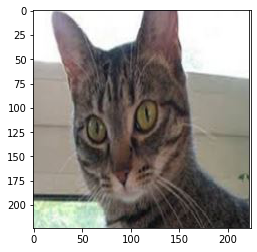

In [11]:
img_path = 'C:/Users/johan/Downloads/cat.JPG'
img = np.array(image.load_img(img_path, target_size=(224, 224)))
plt.imshow(img)
preprocess = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = preprocess(img).double()

# normalize
mean = torch.FloatTensor([0.485, 0.456, 0.406]) 
std = torch.FloatTensor([0.229, 0.224, 0.225])
mean = mean[..., :, None, None]
std = std[..., :, None, None]
input_transformed = (input_tensor - mean) / std

input_transformed = input_transformed.unsqueeze_(0)
input_tensor = input_tensor.unsqueeze_(0)

model = models.alexnet(pretrained=True).double()
model.eval()
output = model(input_transformed)
_, orig_label = torch.max(output, 1)
print(orig_label.item())
print('285: Egyptian cat')
y_target = torch.from_numpy(np.array([orig_label.item()])).long()
_img = input_tensor.clone().detach().requires_grad_(True)

We define a separate function for the normalization as we will need to call it in every gradient step.

In [13]:
def normalize_diff(tensor):
    mean = torch.FloatTensor([0.485, 0.456, 0.406]) 
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    mean = mean[..., :, None, None]
    std = std[..., :, None, None]
    out = (tensor - mean) / std
    return out

Next, we do a sanity check on the transformation layers. We apply saturation, contrast and brightness adjustment, 
first with a factor of *1.2 and then with a factor of *0.8.

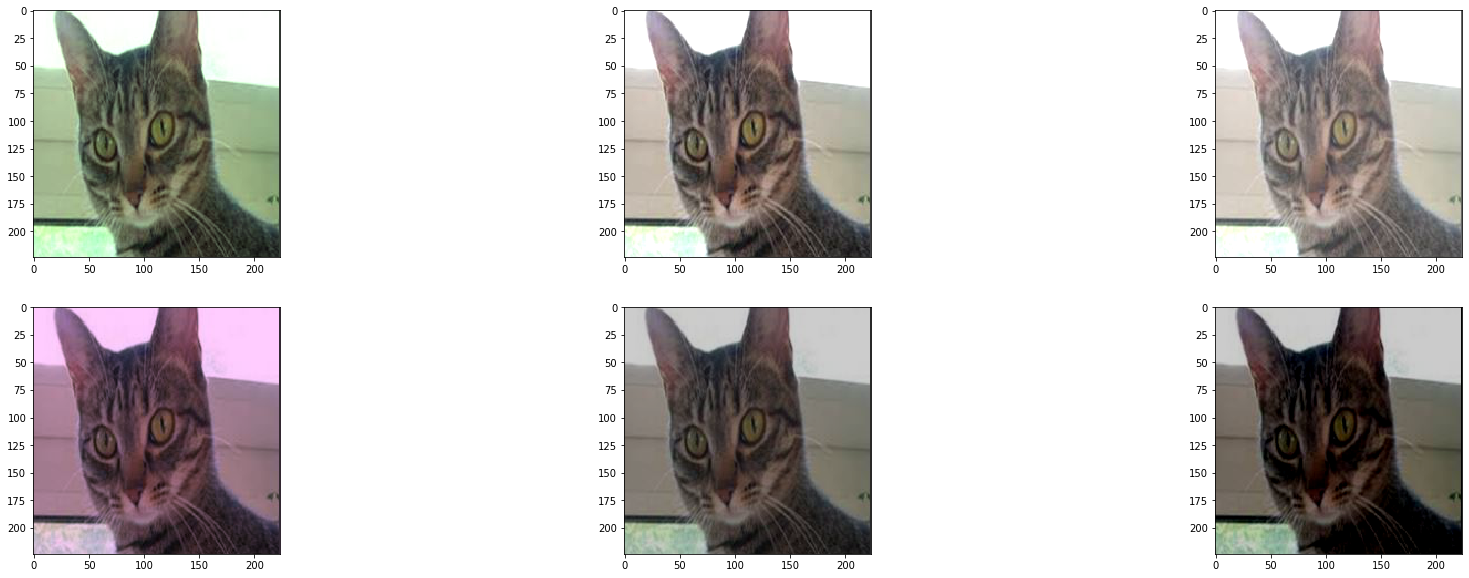

In [12]:
f, axarr = plt.subplots(2, 3, figsize=(30, 10))

s = Saturation(factor=1.2)
out = s.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[0][0].imshow(out)
s = Saturation(factor=0.8)
out = s.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[1][0].imshow(out)

c = Contrast(factor=1.2)
out = c.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[0][1].imshow(out)
c = Contrast(factor=0.8)
out = c.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[1][1].imshow(out)

b = Brightness(factor=0.2)
out = b.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[0][2].imshow(out)
b = Brightness(factor=-0.2)
out = b.get_tensor(input_tensor)
out = np.swapaxes(np.swapaxes(out.detach().numpy()[0], 0, 2), 0, 1)
axarr[1][2].imshow(out)
plt.show()

Now we can use this to maximize the loss. As an initial experiment we just do gradient descent for 10 steps 
without any constraints

factors after 15 gradient steps:  [ 1.30286637  1.31009778 -0.23524448]
predicted class:  tensor([281])
281: tabby, tabby cat


Text(0.5, 0, 'gradient step')

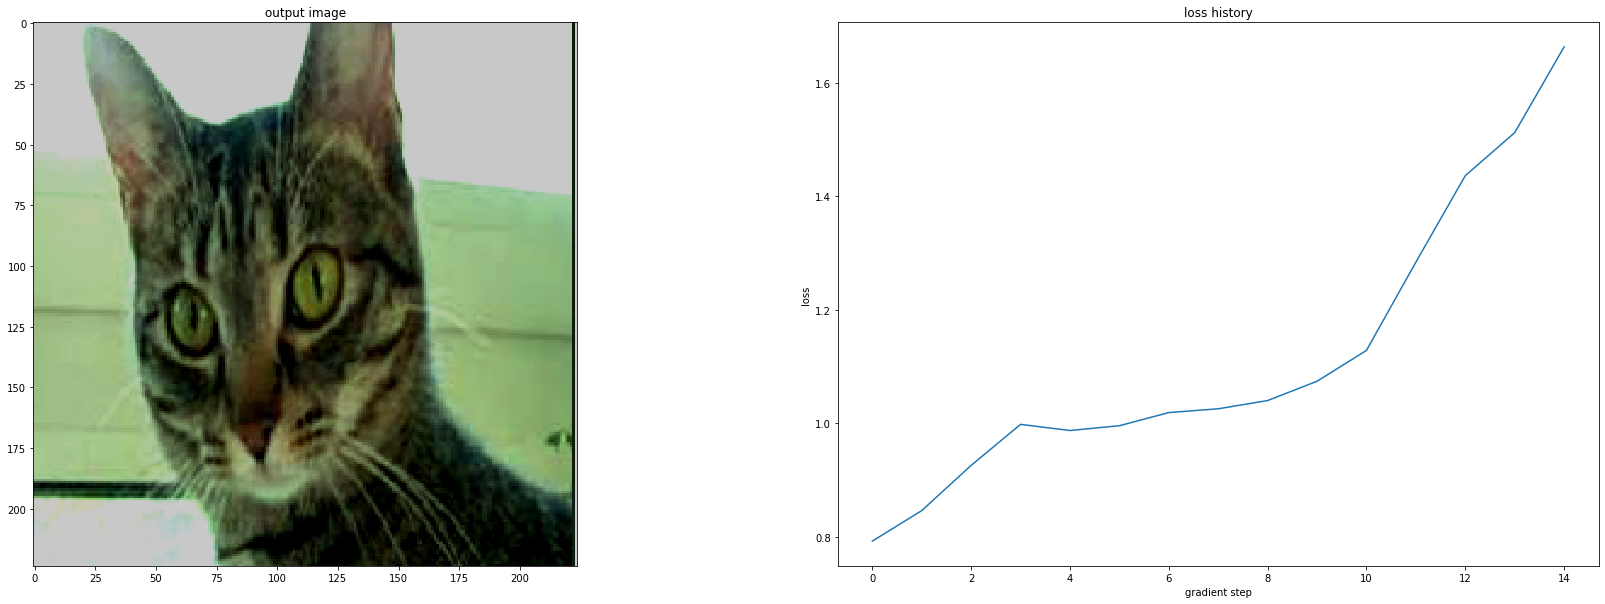

In [35]:
# initialize saturation, contrast, brightness
xs = [[1.0, 1.0, 0.0]]
step_size = 0.03
loss_hist = []
for i in range(0, 15):
    s = Saturation(factor=xs[i][0])
    s_out = s.get_tensor(_img=_img)
    c = Contrast(factor=xs[i][1])
    c_out = c.get_tensor(_img=s_out)
    b = Brightness(factor=xs[i][2])
    b_out = b.get_tensor(_img=c_out)
    
    norm_out = normalize_diff(b_out)
    output = model(norm_out)
    loss = nn.CrossEntropyLoss()(output, y_target)
    loss_hist.append(loss)
    # print('loss: ', loss)
    # print('factors: ', xs)
    c.retain_grad()
    b.retain_grad()
    loss.backward()
    
    gradients = np.array([s.get_gradient(),
                 c.get_gradient(),
                 b.get_gradient()])
    # print('gradients:', gradients)

    updated = xs[i] + step_size * gradients
    xs = np.append(xs, [updated], axis=0)
print('factors after 15 gradient steps: ', xs[-1])
_, fin_label = torch.max(output, 1)
print('predicted class: ', fin_label)
print('281: tabby, tabby cat')
f, axarr = plt.subplots(1, 2, figsize=(30, 10))
axarr[0].imshow(np.swapaxes(np.swapaxes(b_out.detach().numpy()[0], 0, 2), 0, 1))
axarr[0].set_title('output image')
axarr[1].plot(loss_hist)
axarr[1].set_title('loss history')
axarr[1].set_ylabel('loss')
axarr[1].set_xlabel('gradient step')

Next we conduct the same experiment, but with projections on a box of constraints. 
  

factors after 100 gradient steps:  [ 1.00175188  1.00295642 -0.05683217]
predicted class:  tensor([281])
281: tabby, tabby cat


Text(0.5, 0, 'gradient step')

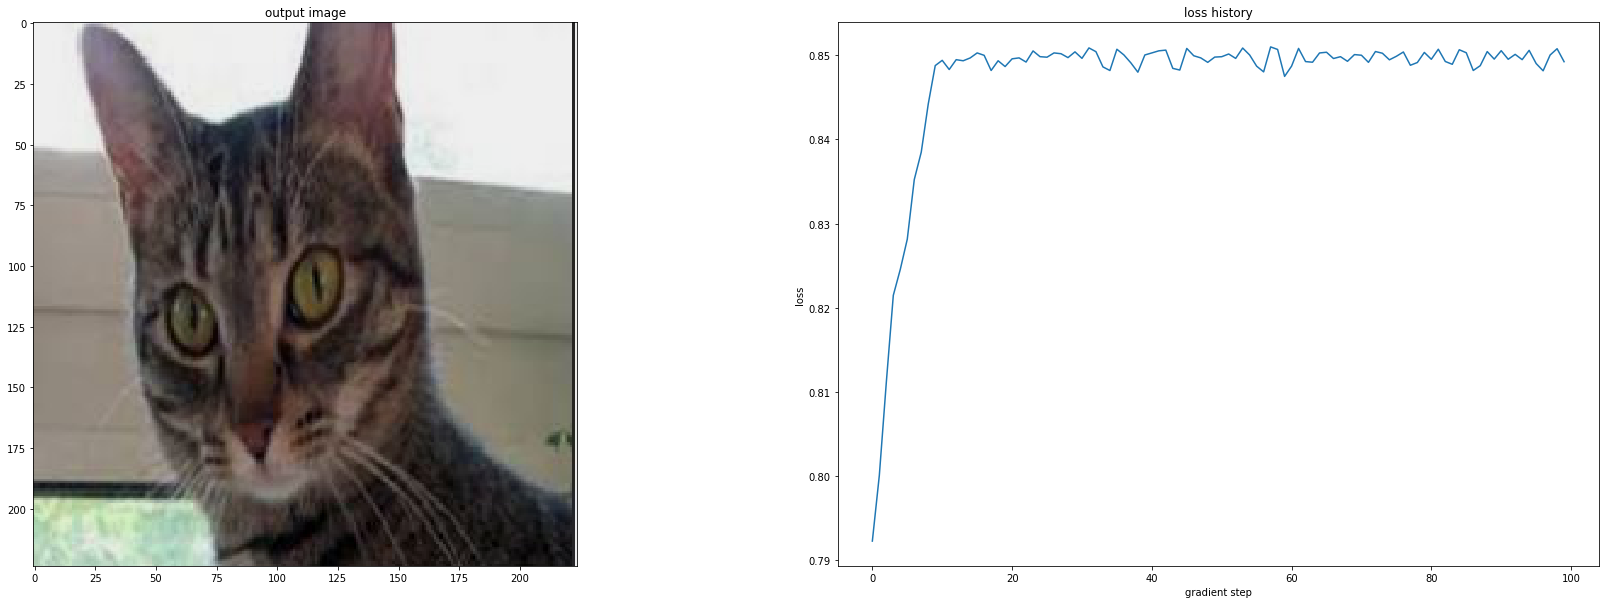

In [36]:
def project(factors):
    min = [0.4, 0.4, -0.6]
    max = [1.6, 1.6, 0.6]
    return np.minimum(np.maximum(min, factors), max)

# initialize saturation, contrast, brightness
xs = [[1.0, 1.0, 0.0]]
step_size = 0.005
loss_hist = []
for i in range(0, 100):
    s = Saturation(factor=xs[i][0])
    s_out = s.get_tensor(_img=_img)
    c = Contrast(factor=xs[i][1])
    c_out = c.get_tensor(_img=s_out)
    b = Brightness(factor=xs[i][2])
    b_out = b.get_tensor(_img=c_out)
    
    norm_out = normalize_diff(b_out)
    output = model(norm_out)
    loss = nn.CrossEntropyLoss()(output, y_target)
    loss_hist.append(loss)
    # print('loss: ', loss)
    # print('factors: ', xs)
    c.retain_grad()
    b.retain_grad()
    loss.backward()
    
    gradients = np.array([s.get_gradient(),
                 c.get_gradient(),
                 b.get_gradient()])
    # print('gradients:', gradients)

    updated = xs[i] + step_size * gradients
    projection = project(updated)
    xs = np.append(xs, [projection], axis=0)
print('factors after 100 gradient steps: ', xs[-1])
_, fin_label = torch.max(output, 1)
print('predicted class: ', fin_label)
print('281: tabby, tabby cat')
f, axarr = plt.subplots(1, 2, figsize=(30, 10))
axarr[0].imshow(np.swapaxes(np.swapaxes(b_out.detach().numpy()[0], 0, 2), 0, 1))
axarr[0].set_title('output image')
axarr[1].plot(loss_hist)
axarr[1].set_title('loss history')
axarr[1].set_ylabel('loss')
axarr[1].set_xlabel('gradient step')

We do another run of the same experiment with different hyperparameters.

factors after 50 gradient steps:  [ 1.6         1.38720443 -0.6       ]
predicted class:  tensor([440])
 440: beer bottle


Text(0.5, 0, 'gradient step')

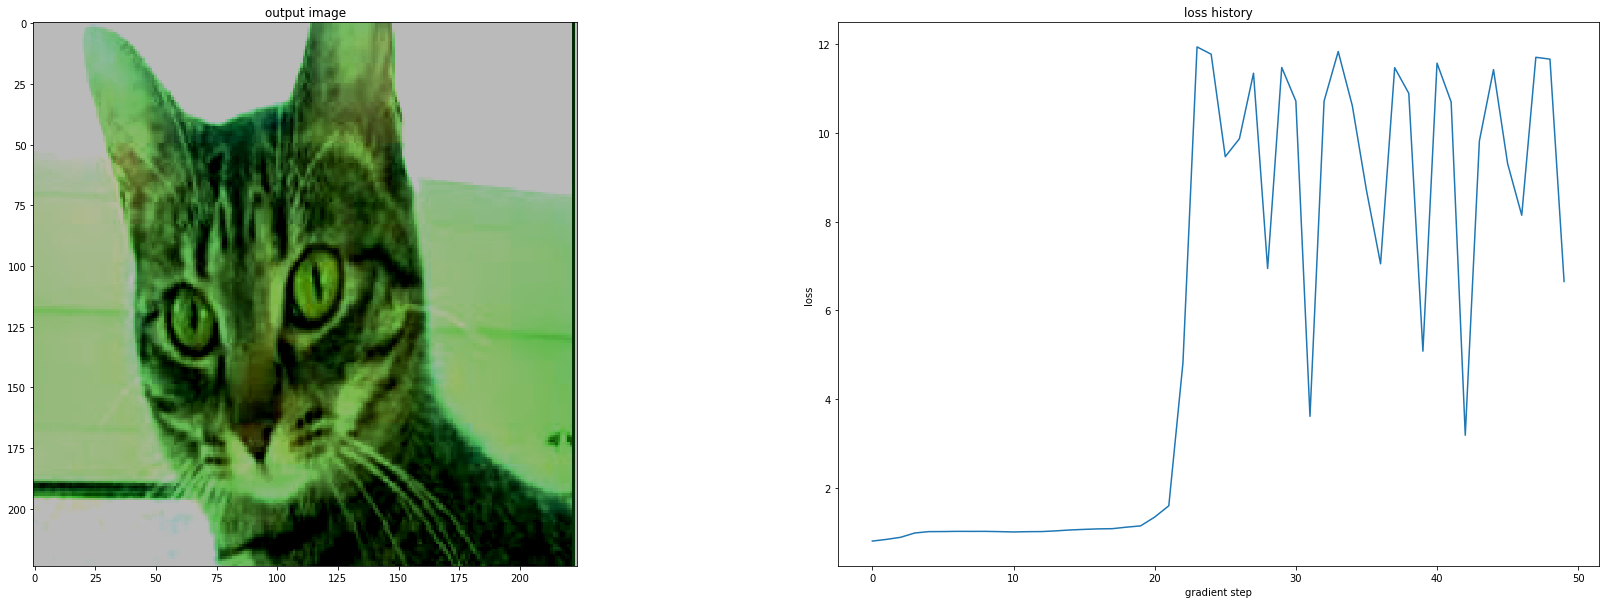

In [37]:
# initialize saturation, contrast, brightness
xs = [[1.0, 1.0, 0.0]]
step_size = 0.02
loss_hist = []
for i in range(0, 50):
    s = Saturation(factor=xs[i][0])
    s_out = s.get_tensor(_img=_img)
    c = Contrast(factor=xs[i][1])
    c_out = c.get_tensor(_img=s_out)
    b = Brightness(factor=xs[i][2])
    b_out = b.get_tensor(_img=c_out)
    
    norm_out = normalize_diff(b_out)
    output = model(norm_out)
    loss = nn.CrossEntropyLoss()(output, y_target)
    loss_hist.append(loss)
    # print('loss: ', loss)
    # print('factors: ', xs)
    c.retain_grad()
    b.retain_grad()
    loss.backward()
    
    gradients = np.array([s.get_gradient(),
                 c.get_gradient(),
                 b.get_gradient()])
    # print('gradients:', gradients)

    updated = xs[i] + step_size * gradients
    projection = project(updated)
    xs = np.append(xs, [projection], axis=0)
print('factors after 50 gradient steps: ', xs[-1])
_, fin_label = torch.max(output, 1)
print('predicted class: ', fin_label)
print(' 440: beer bottle')
f, axarr = plt.subplots(1, 2, figsize=(30, 10))
axarr[0].imshow(np.swapaxes(np.swapaxes(b_out.detach().numpy()[0], 0, 2), 0, 1))
axarr[0].set_title('output image')
axarr[1].plot(loss_hist)
axarr[1].set_title('loss history')
axarr[1].set_ylabel('loss')
axarr[1].set_xlabel('gradient step')

Experiment Summary:
-